In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load the dataset
import pandas as pd

# Load UFO data
df = pd.read_csv('/content/drive/MyDrive/UFO/scrubbed_data.csv')
df.head()


<ipython-input-2-4e3e34c48e1f>:5: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/UFO/scrubbed_data.csv')


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [3]:
# Preprocessing the description text
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['cleaned_description'] = df['comments'].apply(clean_text)
df[['comments', 'cleaned_description']].head()

,comments,cleaned_description
0,This event took place in early fall around 194...,this event took place in early fall around 194...
1,1949 Lackland AFB&#44 TX. Lights racing acros...,1949 lackland afb44 tx lights racing across th...
2,Green/Orange circular disc over Chester&#44 En...,greenorange circular disc over chester44 england
3,My older brother and twin sister were leaving ...,my older brother and twin sister were leaving ...
4,AS a Marine 1st Lt. flying an FJ4B fighter/att...,as a marine 1st lt flying an fj4b fighterattac...


## VADER

In [4]:
# VADER Sentiment Analysis
!pip install -q vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()
df['vader_score'] = df['cleaned_description'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

def vader_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_score'].apply(vader_label)
df[['cleaned_description', 'vader_score', 'vader_sentiment']].head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00


,cleaned_description,vader_score,vader_sentiment
0,this event took place in early fall around 194...,0.0000,neutral
1,1949 lackland afb44 tx lights racing across th...,0.3612,positive
2,greenorange circular disc over chester44 england,0.0000,neutral
3,my older brother and twin sister were leaving ...,0.0000,neutral
4,as a marine 1st lt flying an fj4b fighterattac...,-0.2960,negative


<ipython-input-5-be5c4ebe2a18>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='vader_sentiment', palette='Set2', order=['positive', 'neutral', 'negative'])


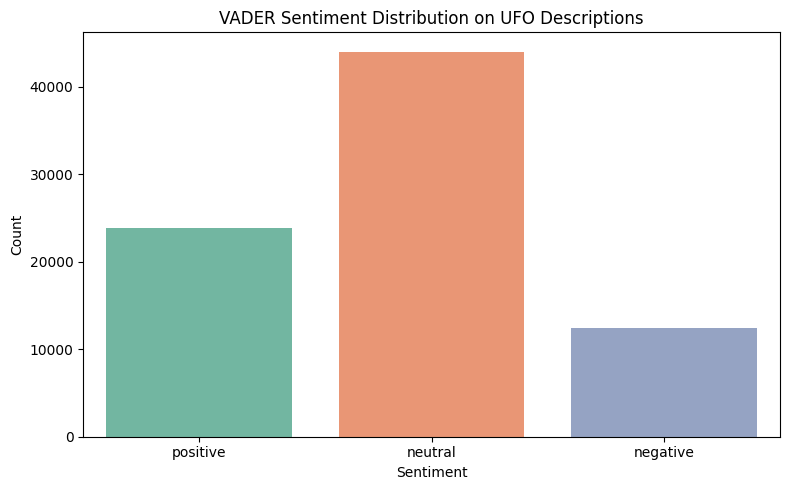

In [5]:
# Visualize VADER sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='vader_sentiment', palette='Set2', order=['positive', 'neutral', 'negative'])
plt.title('VADER Sentiment Distribution on UFO Descriptions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## DistilBERT

In [6]:
# DistilBERT-based Sentiment Analysis
!pip install -q transformers
from transformers import pipeline

sentiment_pipeline = pipeline('sentiment-analysis')

# Run on a smaller subset for speed
sampled_df = df.sample(n=1000, random_state=42).copy()
sampled_df['bert_result'] = sampled_df['cleaned_description'].apply(lambda x: sentiment_pipeline(x)[0])
sampled_df['bert_label'] = sampled_df['bert_result'].apply(lambda x: x['label'])
sampled_df['bert_score'] = sampled_df['bert_result'].apply(lambda x: x['score'])

sampled_df[['cleaned_description', 'bert_label', 'bert_score']].head()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,cleaned_description,bert_label,bert_score
9203,3 red objects that were bright red44 2 were cl...,NEGATIVE,0.934152
77843,it really could have been a jet way up there b...,NEGATIVE,0.995514
74664,we saw a large silver and brightly coloured ci...,NEGATIVE,0.996661
2623,pulsating ufo slowly descended and stayed hove...,NEGATIVE,0.950346
42555,a blueish green ball of light that took off on...,NEGATIVE,0.996325


<ipython-input-7-8db73a1204a0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sampled_df, x='bert_label', palette='Set1')


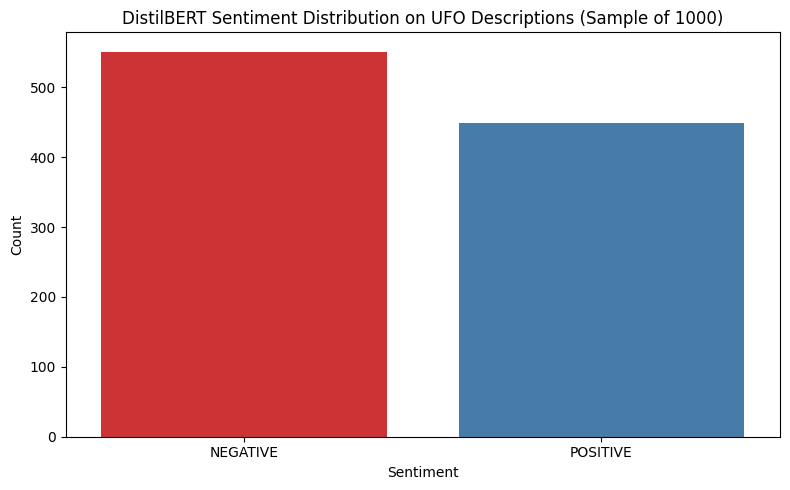

In [7]:
# Visualize BERT sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=sampled_df, x='bert_label', palette='Set1')
plt.title('DistilBERT Sentiment Distribution on UFO Descriptions (Sample of 1000)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### DistilBERT on Whole Dataset

In [9]:
# running on while dataset

# Run on a smaller subset for speed
df['bert_result'] = df['cleaned_description'].apply(lambda x: sentiment_pipeline(x)[0])
df['bert_label'] = df['bert_result'].apply(lambda x: x['label'])
df['bert_score'] = df['bert_result'].apply(lambda x: x['score'])

df[['cleaned_description', 'bert_label', 'bert_score']].head()

,cleaned_description,bert_label,bert_score
0,this event took place in early fall around 194...,NEGATIVE,0.967451
1,1949 lackland afb44 tx lights racing across th...,POSITIVE,0.937435
2,greenorange circular disc over chester44 england,POSITIVE,0.611463
3,my older brother and twin sister were leaving ...,POSITIVE,0.533956
4,as a marine 1st lt flying an fj4b fighterattac...,NEGATIVE,0.998538


<ipython-input-10-9f06fcc37dcb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='bert_label', palette='Set2')


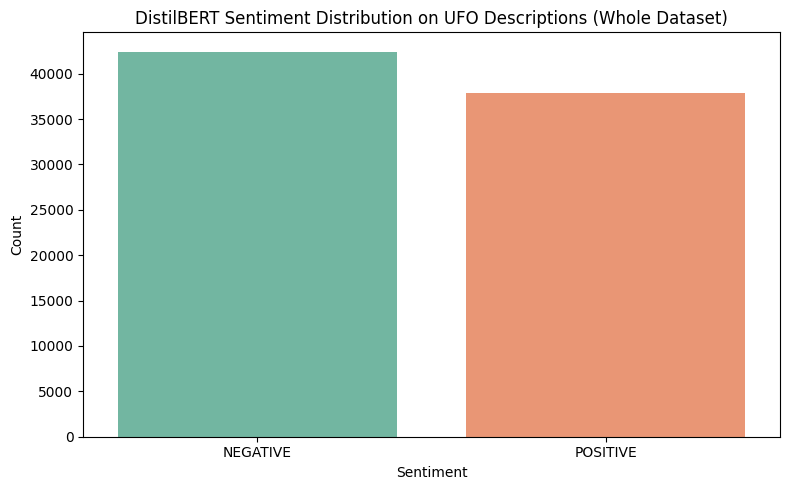

In [10]:
# Visualize BERT sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='bert_label', palette='Set2')
plt.title('DistilBERT Sentiment Distribution on UFO Descriptions (Whole Dataset)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Sentiment vs. Time


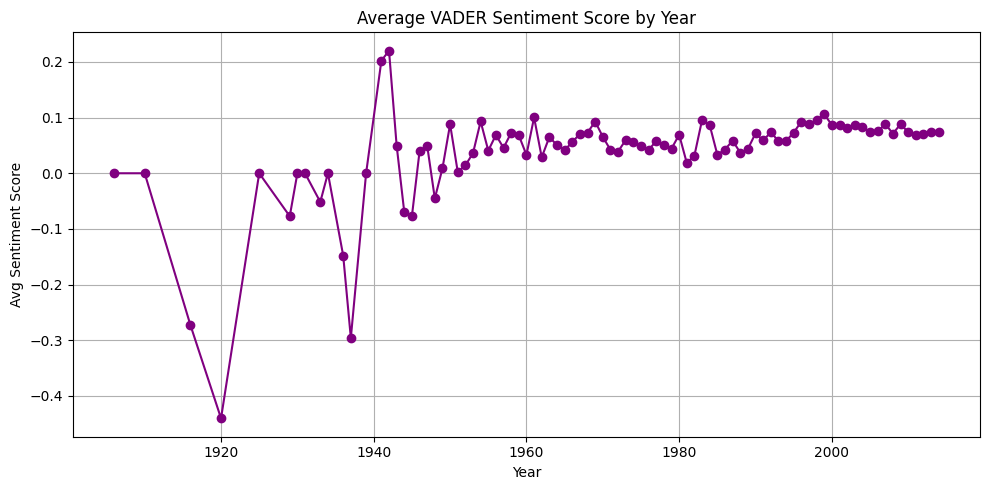

In [11]:
# Sentiment vs Year
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['year'] = df['datetime'].dt.year

yearly_sentiment = df.groupby('year')['vader_score'].mean()

plt.figure(figsize=(10, 5))
yearly_sentiment.plot(marker='o', color='purple')
plt.title('Average VADER Sentiment Score by Year')
plt.xlabel('Year')
plt.ylabel('Avg Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


## Sentiment vs. Location

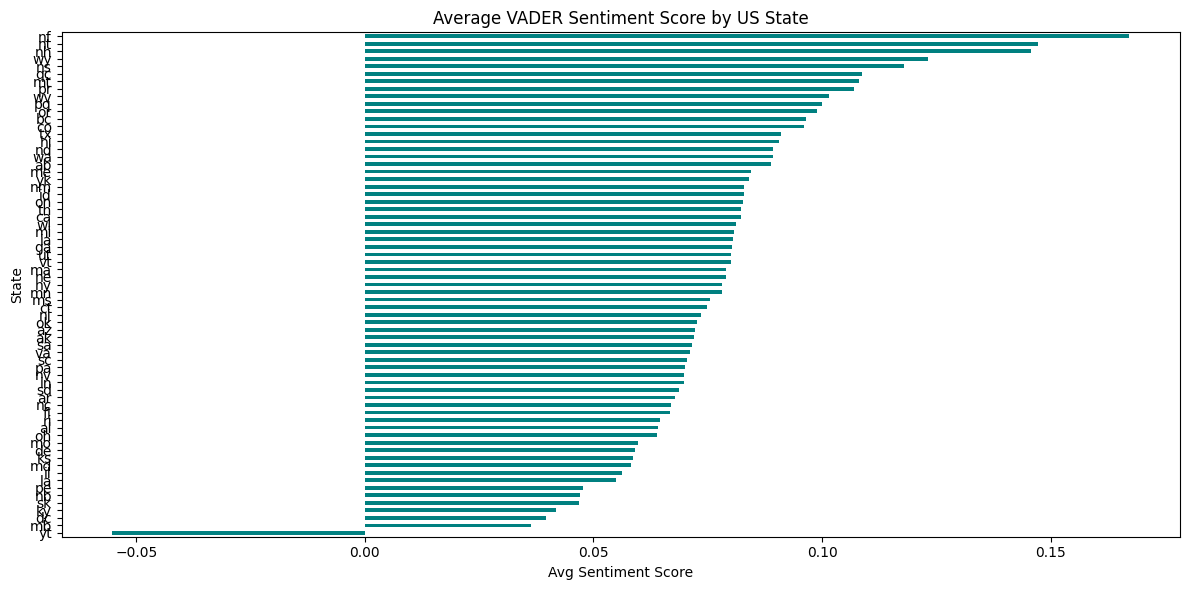

In [12]:
# Sentiment by US State (for example)
state_sentiment = df.groupby('state')['vader_score'].mean().sort_values()

plt.figure(figsize=(12, 6))
state_sentiment.plot(kind='barh', color='teal')
plt.title('Average VADER Sentiment Score by US State')
plt.xlabel('Avg Sentiment Score')
plt.ylabel('State')
plt.tight_layout()
plt.show()


# Advanced Techniques

## 1. Finetuned Transformer Models for Emotion Classification

Model: j-hartmann/emotion-english-distilroberta-base
Output: Multi-class emotion tags like: joy, anger, fear, surprise, disgust, sadness, neutral

In [13]:
# Emotion Classification with DistilRoBERTa (j-hartmann/emotion)
!pip install -q transformers
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load pipeline
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=False)

# Apply to sampled data
sampled_df = df.sample(n=1000, random_state=42).copy()
sampled_df['hartmann_emotion'] = sampled_df['cleaned_description'].apply(lambda x: emotion_classifier(x)[0]['label'])


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


<ipython-input-14-75ab4748e057>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sampled_df, x='hartmann_emotion', order=sampled_df['hartmann_emotion'].value_counts().index, palette='Set2')


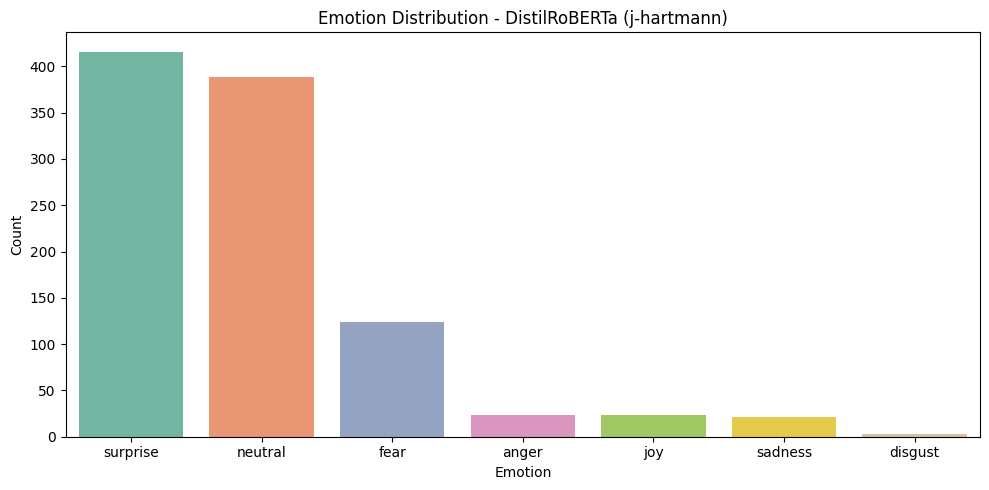

In [14]:
# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=sampled_df, x='hartmann_emotion', order=sampled_df['hartmann_emotion'].value_counts().index, palette='Set2')
plt.title('Emotion Distribution - DistilRoBERTa (j-hartmann)')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 2. Multi-label Sentiment (Positive + Fear + Surprise)
Model: cardiffnlp/twitter-roberta-base-emotion
Trained on tweets but works well on short descriptions.

In [15]:
# Emotion Classification with CardiffNLP Twitter-RoBERTa
!pip install -q transformers torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

model_name = "cardiffnlp/twitter-roberta-base-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ['anger', 'joy', 'optimism', 'sadness']

def classify_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1)
        return labels[scores.argmax().item()]

sampled_df['cardiff_emotion'] = sampled_df['cleaned_description'].apply(classify_emotion)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

<ipython-input-16-d5b2eed3abe5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sampled_df, x='cardiff_emotion', order=sampled_df['cardiff_emotion'].value_counts().index, palette='Set1')


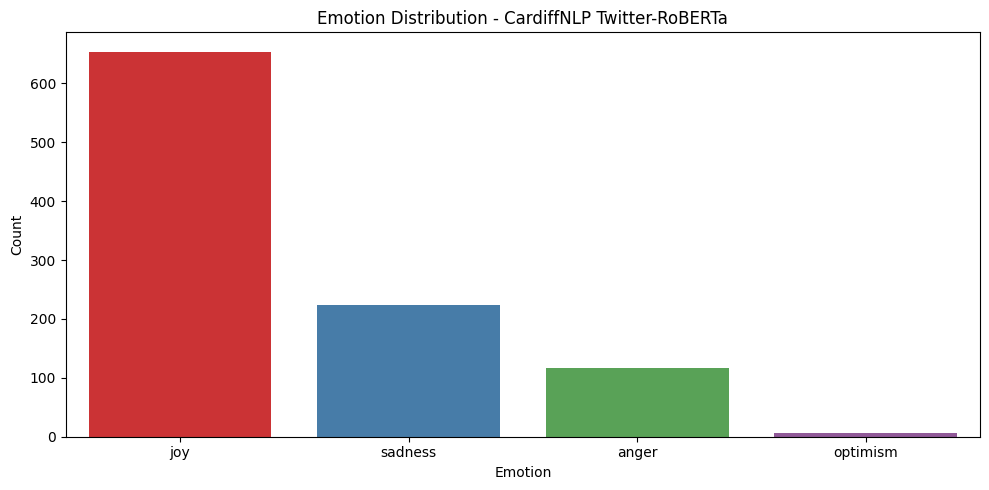

In [16]:
# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=sampled_df, x='cardiff_emotion', order=sampled_df['cardiff_emotion'].value_counts().index, palette='Set1')
plt.title('Emotion Distribution - CardiffNLP Twitter-RoBERTa')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 3. Zero-shot Classification for Sentiment/Emotion Themes
If you want custom labels (e.g., fear, confusion, amazement), you can use zero-shot-classification:

In [17]:
# Zero-shot Classification with Custom Emotion Labels
zero_shot = pipeline("zero-shot-classification")
custom_labels = ["fear", "amazement", "confusion", "excitement", "anger", "indifference"]

sampled_df['zero_shot_emotion'] = sampled_df['cleaned_description'].apply(
    lambda x: zero_shot(x, candidate_labels=custom_labels)['labels'][0]
)


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


<ipython-input-18-c12b4a2bfb4e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sampled_df, x='zero_shot_emotion', order=sampled_df['zero_shot_emotion'].value_counts().index, palette='coolwarm')


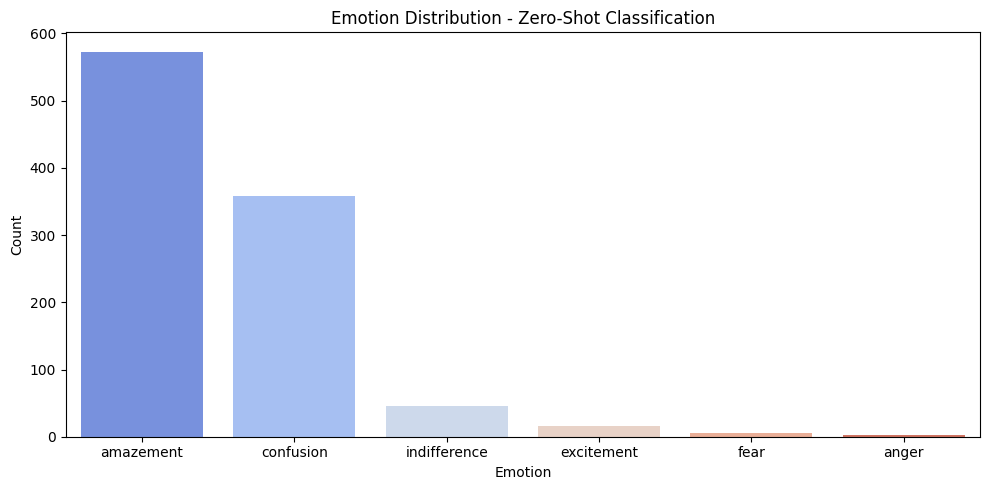

In [18]:
# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=sampled_df, x='zero_shot_emotion', order=sampled_df['zero_shot_emotion'].value_counts().index, palette='coolwarm')
plt.title('Emotion Distribution - Zero-Shot Classification')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4. Sentence Embeddings + Clustering (Unsupervised Sentiment)
USentence-BERT + KMeans — you may discover natural groupings like:

“blinking lights above house”

“loud metallic hum before craft”

“lost time and missing hours”

Not sentiment per se, but powerful for latent emotional themes.

In [19]:
# Sentence-BERT + Clustering
!pip install -q sentence-transformers scikit-learn
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Embed descriptions
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sampled_df['cleaned_description'].tolist(), show_progress_bar=True)

# KMeans Clustering
kmeans = KMeans(n_clusters=6, random_state=42)
sampled_df['cluster'] = kmeans.fit_predict(embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

<ipython-input-20-8f2d0264f164>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sampled_df, x='cluster', palette='Accent')


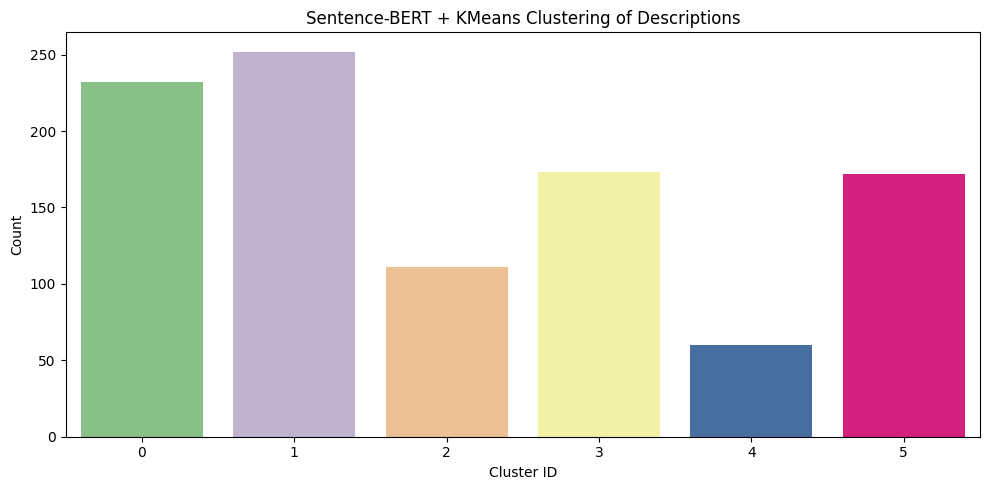


Cluster 0 Examples:
a blueish green ball of light that took off on ...
the object was triangular44 totally silent and ...
fast neon green object over ga 400 north of cum...

Cluster 1 Examples:
3 red objects that were bright red44 2 were clo...
large yellow bright light observed too low and ...
two bright lights following each other seen in ...

Cluster 2 Examples:
pulsating ufo slowly descended and stayed hover...
bright starlike craft flying over the valley ju...
                    10 year old local boy sees ufo

Cluster 3 Examples:
it really could have been a jet way up there bu...
we saw a large silver and brightly coloured cig...
my age was 8 at the time and i was in bed just ...

Cluster 4 Examples:
070411 university place44 wa spherical ufo with...
orange flamed fireball spotted from ajman beach...
ball of flames moving slowly across the night s...

Cluster 5 Examples:
man w wife witness bizarre quotgrayish yellow l...
looking up north in the sky44 probably above sa...
       

In [20]:
# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=sampled_df, x='cluster', palette='Accent')
plt.title('Sentence-BERT + KMeans Clustering of Descriptions')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Show examples from each cluster
for i in range(6):
    print(f"\nCluster {i} Examples:")
    print(sampled_df[sampled_df['cluster'] == i]['cleaned_description'].head(3).to_string(index=False))
